In [76]:
from sklearn.datasets import load_iris 
import pandas as pd 
import numpy as np 
from sklearn.base import BaseEstimator,TransformerMixin 
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
np.set_printoptions(precision=4)

In [77]:
import pandas as pd 
df_wine=pd.read_csv(r'D:\Python machine learning\datasets\wine\wine.data')
df_wine.columns=['Class label', 'Alcohol',
                    'Malic acid', 'Ash',
                    'Alcalinity of ash', 'Magnesium',
                    'Total phenols', 'Flavanoids',
                    'Nonflavanoid phenols',
                    'Proanthocyanins',
                    'Color intensity', 'Hue',
                    'OD280/OD315 of diluted wines',
                    'Proline'] 
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


In [78]:
class lda(BaseEstimator,TransformerMixin):
    def __init__(self,k=2):
        self.k=k 

    
    def fit(self,X,y):
        self.sc_=StandardScaler()
        X_std=self.sc_.fit_transform(X)

        en=LabelEncoder()
        y_en=en.fit_transform(y)
        y=y_en 

        labels=np.unique(y)


        #first we will calculate the class specific mean values

        mean_vecs=[]
        for i in labels:
            #taking the mean for each class wrt feature/column and not row/sample
            samples=X_std[y==i].mean(axis=0) 
            mean_vecs.append(samples)

        
        #now we will calculate the SW within class scatter matrix / just taking the covariance of the sample that belong to one specific class
        N=X.shape[1]
        S_W=np.zeros(shape=(N,N))

        for i in labels:
            S_W+=np.cov(X_std[y==i].T)


        
        #now we will calculate the SB betwen class scatter matrix 
        S_B=np.zeros(shape=(N,N))
        #taking the mean wrt to features/column and not row/samples
        mean_overall=X_std.mean(axis=0)
        for i,meanvec in zip(labels,mean_vecs):
            n=X_std[y==i].shape[0]
            meanvec=meanvec.reshape(-1,1)
            S_B+=n * (meanvec-mean_overall).dot((meanvec-mean_overall).T)

        
        #now we will take the inverse of the SW and dot it with SB and then decompose it it eigen value and eigen vector
        eigen_val,eigen_vec=np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

        #now we will pair up the eigen value and eigen vector and sort it according to the eigen value in descending order
        eigen_pair=[(np.abs(eigen_val[i]),eigen_vec[:,i]) for i in range(len(eigen_val))]

        eigen_pair=sorted(eigen_pair,key=lambda x:x[0],reverse=True)

        #now we will take the first k eigen vectors
        self.T_= np.column_stack([eigen_pair[i][1][:,np.newaxis] for i in range(self.k)])

        return self 
    

    def transform(self,X):
        X=self.sc_.transform(X)

        return np.dot(X,self.T_) 


In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts 
X,y=df_wine.iloc[:,1:].values,df_wine.iloc[:,0].values

X_train,X_test,y_train,y_test=tts(X,y,test_size=0.3,stratify=y,random_state=0)

ld=lda()
X_train_lda=ld.fit_transform(X_train,y_train)
X_test_lda=ld.transform(X_test)

d:\anaconda\Lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


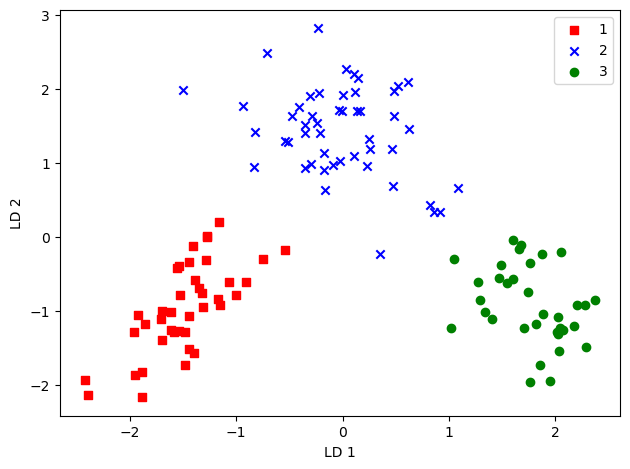

In [80]:
import matplotlib.pyplot as plt

color=['r','b','g']
markers=['s','x','o']

for l,m,c in zip(np.unique(y),markers,color):
    plt.scatter(X_train_lda[y_train==l,0],X_train_lda[y_train==l,1],
                c=c,label=l,marker=m)
    
plt.xlabel('LD 1')                                                
plt.ylabel('LD 2')

plt.legend(loc='best')
plt.tight_layout()
plt.show()